In [1]:
import xarray as xa
from matplotlib import pyplot as plt
import cartopy
import numpy as np
import pandas as pd
from scipy.stats import bootstrap

In [2]:
ERA_map = xa.open_dataset('map_ERA5_gulftrans.nc')
print(ERA_map)

<xarray.Dataset>
Dimensions:        (src_grid_rank: 2, dst_grid_rank: 2, n_a: 1038240, n_b: 640,
                    nv_a: 4, nv_b: 4, n_s: 3259)
Dimensions without coordinates: src_grid_rank, dst_grid_rank, n_a, n_b, nv_a,
                                nv_b, n_s
Data variables: (12/17)
    src_grid_dims  (src_grid_rank) int32 ...
    dst_grid_dims  (dst_grid_rank) int32 ...
    yc_a           (n_a) float64 ...
    yc_b           (n_b) float64 ...
    xc_a           (n_a) float64 ...
    xc_b           (n_b) float64 ...
    ...             ...
    area_b         (n_b) float64 ...
    frac_a         (n_a) float64 ...
    frac_b         (n_b) float64 ...
    row            (n_s) int32 ...
    col            (n_s) int32 ...
    S              (n_s) float64 ...
Attributes: (12/15)
    Title:          TempestRemap Offline Regridding Weight Generator
    bubble:         true
    concave_dst:    false
    concave_src:    false
    domain_a:       ERA5.g
    domain_b:       gulftrans.g
    .

In [3]:
ERA_map.yv_b

<xarray.DataArray 'yv_b' (n_b: 640, nv_b: 4)>
[2560 values with dtype=float64]
Dimensions without coordinates: n_b, nv_b
Attributes:
    units:    degrees

In [4]:
ERA_map.xv_b

<xarray.DataArray 'xv_b' (n_b: 640, nv_b: 4)>
[2560 values with dtype=float64]
Dimensions without coordinates: n_b, nv_b
Attributes:
    units:    degrees

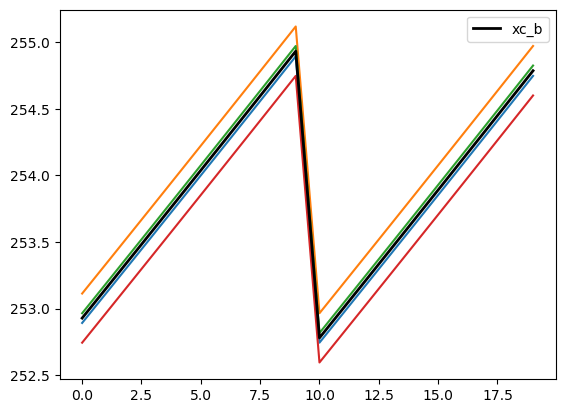

In [5]:
plt.plot(ERA_map.xv_b[:20, 0])
plt.plot(ERA_map.xv_b[:20, 1])
plt.plot(ERA_map.xv_b[:20, 2])
plt.plot(ERA_map.xv_b[:20, 3])
plt.plot(ERA_map.xc_b[:20], label='xc_b', linewidth=2, color='black')
plt.legend()
plt.show()

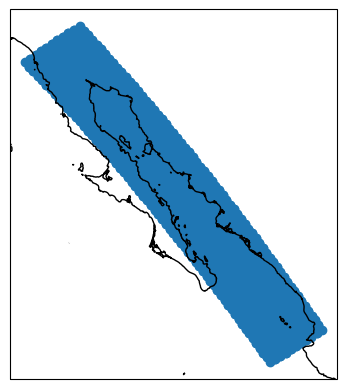

(640, 4)


In [6]:
fig = plt.figure()
ax = fig.add_subplot(projection=cartopy.crs.PlateCarree())
ax.scatter(ERA_map.xv_b, ERA_map.yv_b, transform=cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.COASTLINE)
plt.show()
print(ERA_map.xv_b.shape)

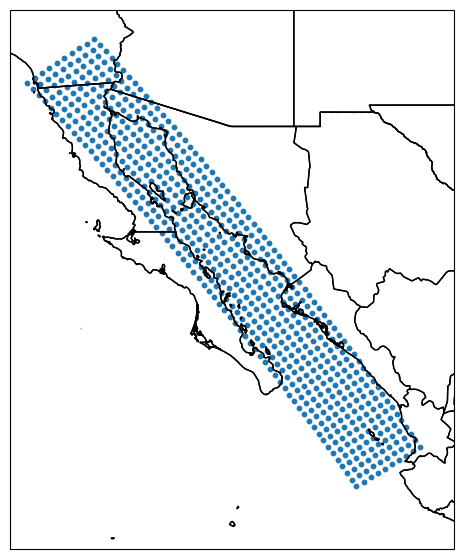

(640,)


In [7]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(projection=cartopy.crs.PlateCarree())
ax.scatter(ERA_map.xc_b, ERA_map.yc_b, transform=cartopy.crs.PlateCarree(), s=10)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'))
ax.set_extent([-118, -104, 18, 35], crs=cartopy.crs.PlateCarree())
plt.show()
print(ERA_map.xc_b.shape)

In [8]:
def start_end_time(sub_id):
    start = []
    end = []
    ext_times = ext_days[sub_id]
    length = len(ext_times)
    i = 0
    while i <= length - 1:
        j = 1
        while (j + i <= length - 1) and ((ext_times[i + j] - ext_times[i + j - 1]) / np.timedelta64(1, 'D') == 1):
            j += 1
        start.append(ext_times[i] - np.timedelta64(12, 'h'))
        end.append(ext_times[i + j - 1] + np.timedelta64(12, 'h'))
        i += j
    return start, end


def is_monsoon_precip(month):
    return (month <= 9) & (month >= 6)

In [9]:
data = xa.open_dataarray("../cpc-global/NAM_sub_precip")  # CPC
monsoon_precip = data.sel(time=(is_monsoon_precip(data.time.dt.month)))
monsoon_precip = monsoon_precip.sel(time=(monsoon_precip.time.dt.year < 2019))
del data
ext_days = {}
for sub_id in range(1, 8):
    print("sub_id: ", sub_id)
    precip = monsoon_precip.sel(sub_id=sub_id)
    precip_data = precip.data
    q1 = np.quantile(precip_data[precip_data > 1], 0.05)
    q2 = np.quantile(precip_data[precip_data > 1], 0.95)
    ext_time = precip.where(precip > q2, drop=True).time.data
    print(len(ext_time), q2)
    ext_days[sub_id] = ext_time

sub_id:  1
39 21.363590636973544
sub_id:  2


/global/homes/d/duan0000/.conda/envs/duan/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


38 7.98353434112839
sub_id:  3
37 7.6309751208430425
sub_id:  4
77 6.2968948209451305
sub_id:  5
118 6.469523059079158
sub_id:  6
124 10.647874758983226
sub_id:  7
153 17.252742222601025


In [10]:
class Surge:
    def __init__(self, start_time, end_time):
        self.start_time = start_time
        self.end_time = end_time
        self.length = (end_time-start_time)/np.timedelta64(1, 'h')
def load_Surge():
    surge_data_6h = "MoistureSurge-6h.nc"
    surge_data_6h = xa.open_dataset(surge_data_6h)
    print('SURGE: ', surge_data_6h)

    surge_record_6h = []
    for i in range(529):
        surge = Surge(start_time=surge_data_6h.start_time.data[i], end_time=surge_data_6h.end_time.data[i])
        surge_record_6h.append(surge)
    return surge_record_6h
surge = load_Surge()
print(len(surge))

SURGE:  <xarray.Dataset>
Dimensions:     (index: 529)
Coordinates:
  * index       (index) int64 0 1 2 3 4 5 6 7 ... 522 523 524 525 526 527 528
Data variables:
    start_time  (index) datetime64[ns] ...
    end_time    (index) datetime64[ns] ...
529


In [11]:
def surge_com(sub_id):
    precip_sub = monsoon_precip.sel(sub_id=sub_id) # daily
    month_date = precip_sub.time.dt.strftime("%m-%d")
    precip_sub = precip_sub.assign_coords(month_date=("time", month_date.data))
    precip_sub_climate = precip_sub.groupby(precip_sub.month_date).mean()
    precip_anomaly = precip_sub.groupby(precip_sub.month_date) - precip_sub_climate
    precip_com = []
    for s in surge:
        start = s.start_time
        start = pd.to_datetime(start)
        day = start.day
        month = start.month
        year = start.year
        timeindex = np.datetime64(str(year)+'-'+str(month).zfill(2)+'-'+str(day).zfill(2))
        if start.hour>12:
            timeindex += np.timedelta64(1, 'D')
        if pd.to_datetime(timeindex+np.timedelta64(7 ,'D')).month<=9 and pd.to_datetime(timeindex-np.timedelta64(7 ,'D')).month>=6:
            precip_com.append(precip_anomaly.sel(time=slice(timeindex-np.timedelta64(7 ,'D'), timeindex+np.timedelta64(7 ,'D'))).data.reshape(-1, 1))
    print(len(precip_com))
    return precip_com

In [12]:
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER

500
500
500
500
500
500
500


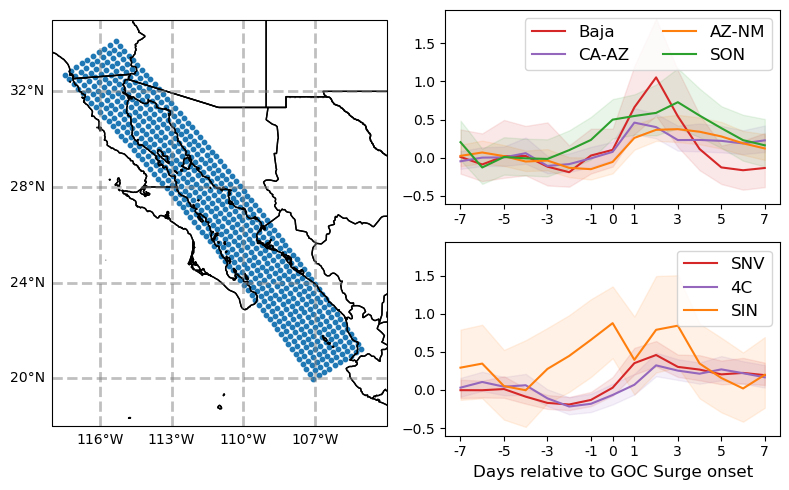

In [14]:
color = ['tab:red', 'tab:purple', 'tab:orange', 'tab:green']
alias = {1:'Baja', 2:'CA-AZ', 3:'SNV', 4:'4C', 5:'AZ-NM', 6:'SON', 7:'SIN'}
# fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 5))
fig = plt.figure(figsize=(8, 5))
gs = GridSpec(nrows=2, ncols=2, figure=fig)
ax = fig.add_subplot(gs[:, 0], projection=cartopy.crs.PlateCarree())
ax.scatter(ERA_map.xc_b, ERA_map.yc_b, transform=cartopy.crs.PlateCarree(), s=10)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'))
ax.set_extent([-118, -104, 18, 35], crs=cartopy.crs.PlateCarree())
gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.bottom_labels = True
gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.ylocator = mticker.FixedLocator([20, 24, 28, 32])
gl.xlocator = mticker.FixedLocator([-116, -113, -110, -107])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax2 = fig.add_subplot(gs[0, 1])
for ind, sub in enumerate([1, 2, 5, 6]):
    precip_com = surge_com(sub)
    precip_com = np.concatenate(precip_com, axis=1)
    precip_com_mean = np.mean(precip_com, axis=1)
    lower = []
    upper = []
    # ax = axes.flatten()[sub-1]
    for i in range(15):
        x_mean = bootstrap((precip_com[i].reshape(-1), ), np.mean)
        lower.append(x_mean.confidence_interval[0])
        upper.append(x_mean.confidence_interval[1])
    ax2.plot(precip_com_mean, label=alias[sub], color=color[(ind)%4])
    ax2.fill_between(np.arange(15), y1=lower, y2=upper, alpha=0.1, color=color[(ind)%4])
    ax2.set_xticks([0, 2, 4, 6, 7, 8, 10, 12, 14])
    # ax2.set_xticklabels(['-7', '-5', '-3', '-1', '0', '1', '3', '5', '7'])
# ax2.set_title('0-Day (concurrent)', fontsize=12)
ax2.legend(fontsize=12, ncol=2)
ax3 = fig.add_subplot(gs[1, 1], sharex=ax2, sharey=ax2)
for ind, sub in enumerate([3, 4, 7]):
    precip_com = surge_com(sub)
    precip_com = np.concatenate(precip_com, axis=1)
    precip_com_mean = np.mean(precip_com, axis=1)
    lower = []
    upper = []
    # ax = axes.flatten()[sub-1]
    for i in range(15):
        x_mean = bootstrap((precip_com[i].reshape(-1), ), np.mean)
        lower.append(x_mean.confidence_interval[0])
        upper.append(x_mean.confidence_interval[1])
    ax3.plot(precip_com_mean, label=alias[sub], color=color[ind%4])
    ax3.fill_between(np.arange(15), y1=lower, y2=upper, alpha=0.1, color=color[ind%4])
    ax3.set_xticks([0, 2, 4, 6, 7, 8, 10, 12, 14])
    ax3.set_xticklabels(['-7', '-5', '-3', '-1', '0', '1', '3', '5', '7'])
ax3.legend(fontsize=12)
ax3.set_xlabel('Days relative to GOC Surge onset', fontsize=12)
plt.tight_layout()
plt.savefig('surge_figure.png', dpi=150, bbox_inches='tight')
plt.show()